In [ ]:
import pandas as pd
import numpy as np
import os
import urllib.request
import json
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("/content/stock_market_data-DAL.csv")
# Display the DataFrame
print(df.head())


         Date    Low   High  Close   Open
0  03-05-2007  20.55  21.95  20.72  21.75
1  04-05-2007  20.70  21.35  20.98  21.05
2  07-05-2007  20.20  21.29  20.36  21.20
3  08-05-2007  19.30  20.00  19.63  20.00
4  09-05-2007  19.63  20.20  19.79  19.75


In [ ]:
df.tail()

,Date,Low,High,Close,Open
4456,16-01-2025,64.840,66.430,66.18,65.44
4457,17-01-2025,65.640,67.000,65.82,66.70
4458,21-01-2025,66.760,68.510,68.34,66.76
4459,22-01-2025,67.200,69.980,67.78,69.77
4460,23-01-2025,67.185,68.658,67.45,68.19


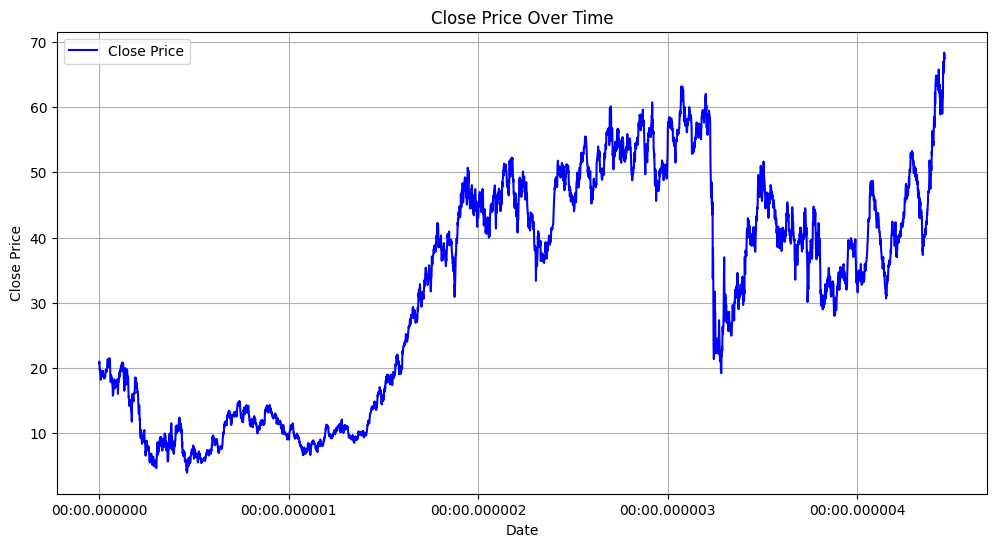

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the Date column is in datetime format
df.index = pd.to_datetime(df.index)  # If Date is the index, ensure it's in datetime format

# Plot Close Price vs. Date
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
features = ['Open', 'High', 'Low']
target = 'Close'

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

In [ ]:
def create_sequences(data, target_index, sequence_length):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :-1])  # All features except target
        y.append(data[i, target_index])          # Target value
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(scaled_data, target_index=-1, sequence_length=sequence_length)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Print dataset shapes
print(f"X_train shape: {X_train.shape}")  # (samples, timesteps, features)
print(f"y_train shape: {y_train.shape}")  # (samples,)

X_train shape: (3878, 10, 3)
y_train shape: (3878,)


In [ ]:
import pandas as pd
import numpy as np
import random
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



In [ ]:
# Function to build RNN model
def build_rnn_model(units, dropout, optimizer, activation):
    model = Sequential()
    model.add(SimpleRNN(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))  # Output layer (Regression output)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Random search hyperparameter tuning
search_space = {
    "units": [50, 100, 150],
    "dropout": [0.1, 0.2, 0.3],
    "optimizer": ["adam", "rmsprop"],
    "activation": ["tanh", "relu"]
}

best_loss = float('inf')
best_hyperparams = {}
num_trials = 10

for trial in range(num_trials):
    # Randomly sample hyperparameters
    params = {key: random.choice(values) for key, values in search_space.items()}
    model = build_rnn_model(**params)
    model.fit(X_train, y_train, epochs=10, batch_sizde=32, verbose=0, validation_data=(X_test, y_test))
    val_loss, val_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Trial {trial + 1}: Loss = {val_loss}, MAE = {val_mae}, Hyperparameters = {params}")
    if val_loss < best_loss:
        best_loss = val_loss
        best_hyperparams = params

print("\nBest Hyperparameters:")
print(best_hyperparams)
print(f"Best Validation Loss: {best_loss}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Trial 1: Loss = 9.252739255316556e-05, MAE = 0.007099163252860308, Hyperparameters = {'units': 100, 'dropout': 0.3, 'optimizer': 'adam', 'activation': 'relu'}
Trial 2: Loss = 0.00011735158477677032, MAE = 0.008358677849173546, Hyperparameters = {'units': 100, 'dropout': 0.1, 'optimizer': 'rmsprop', 'activation': 'relu'}
Trial 3: Loss = 0.00019967000116594136, MAE = 0.011814053170382977, Hyperparameters = {'units': 50, 'dropout': 0.2, 'optimizer': 'adam', 'activation': 'tanh'}
Trial 4: Loss = 0.00010178299271501601, MAE = 0.007593338377773762, Hyperparameters = {'units': 150, 'dropout': 0.3, 'optimizer': 'adam', 'activation': 'tanh'}
Trial 5: Loss = 8.488584717269987e-05, MAE = 0.006961281411349773, Hyperparameters = {'units': 100, 'dropout': 0.1, 'optimizer': 'adam', 'activation': 'relu'}
Trial 6: Loss = 0.00018084360635839403, MAE = 0.011170551180839539, Hyperparameters = {'units': 150, 'dropout': 0.2, 'optimizer': 'rmsprop', 'activation': 'tanh'}
Trial 7: Loss = 8.685853390488774e-05

In [ ]:
model = build_rnn_model(**best_hyperparams)
model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0573 - mae: 0.1453
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - mae: 0.0451
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0364
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mae: 0.0326
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - mae: 0.0309
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mae: 0.0291
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - mae: 0.0291
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - mae: 0.0283
Epoch 9/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - mae: 0.0276
Epoch 10/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - mae: 0.0269
Epoch 11/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - mae: 0.0281
Epoch 12/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - mae: 0.0269
Epoch 13/50
122/122 ━━━━━

In [ ]:
predictions = model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
# Step 1: Reshape X_train to 2D before scaling
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Flatten to 2D for scaling

# Step 2: Fit the feature scaler on the reshaped X_train
feature_scaler = MinMaxScaler()
feature_scaler.fit(X_train_reshaped)  # Fit the scaler

# Step 3: Transform X_train and X_test
X_train_scaled = feature_scaler.transform(X_train_reshaped)

X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_test_scaled = feature_scaler.transform(X_test_reshaped)

# Step 4: Fit the target scaler on y_train
target_scaler = MinMaxScaler()
target_scaler.fit(y_train.reshape(-1, 1))  # Fit the target scaler

# Step 5: Inverse transform X_test and predictions
X_test_original = feature_scaler.inverse_transform(X_test_reshaped)

predictions_original = target_scaler.inverse_transform(predictions)

# Step 6: Inverse transform y_test
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Optional: Combine the inverse-transformed X_test and predictions for further analysis
predictions_combined = np.concatenate((X_test_original, predictions_original), axis=1)

# Ensure no errors in subsequent operations
print("Inverse transformation completed successfully.")


Inverse transformation completed successfully.


In [ ]:

# Debugging outputs to check shapes and correctness
print("X_test_original shape:", X_test_original.shape)
print("Predictions_original shape:", predictions_original.shape)
print("y_test_original shape:", y_test_original.shape)

# Validation: Print first 5 rows of the original vs predicted values for sanity check
for i in range(5):
    print(f"Actual: {y_test_original[i][0]}, Predicted: {predictions_original[i][0]}")


X_test_original shape: (970, 30)
Predictions_original shape: (970, 1)
y_test_original shape: (970, 1)
Actual: 0.3266873672168654, Predicted: 0.32523080706596375
Actual: 0.3332243830691288, Predicted: 0.3359944820404053
Actual: 0.35316228141853234, Predicted: 0.33701303601264954
Actual: 0.3825788527537178, Predicted: 0.3469439148902893
Actual: 0.3711390750122568, Predicted: 0.38492321968078613


In [ ]:
# Inverse transform predictions and y_test
predictions_original = target_scaler.inverse_transform(predictions)
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1))  # Ensure y_test is reshaped

# Output the original values
print(f"Predictions Original: {predictions_original[:5]}")  # Show the first 5 predictions
print(f"y_test Original: {y_test_original[:5]}")  # Show the first 5 actual values


Predictions Original: [[0.3252308 ]
 [0.33599448]
 [0.33701304]
 [0.3469439 ]
 [0.38492322]]
y_test Original: [[0.32668737]
 [0.33322438]
 [0.35316228]
 [0.38257885]
 [0.37113908]]


In [ ]:
# Step 1: Reshape X_train to 2D before scaling
'''
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Flatten to 2D

# Fit the feature scaler on the reshaped X_train
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_reshaped)

# Step 2: Fit the target scaler on y_train
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))  # Remove .values

# Step 3: Inverse transform predictions and X_test
# Reshape X_test in the same way (flatten it to 2D) before inverse scaling
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_test_original = feature_scaler.inverse_transform(X_test_reshaped)

# Inverse transform the predictions using the target scaler
predictions_original = target_scaler.inverse_transform(predictions)

# Step 4: Combine the inverse-transformed X_test and predictions
predictions_combined = np.concatenate((X_test_original, predictions_original), axis=1)
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1))'''

'\nX_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Flatten to 2D\n\n# Fit the feature scaler on the reshaped X_train\nfeature_scaler = MinMaxScaler()\nX_train_scaled = feature_scaler.fit_transform(X_train_reshaped)\n\n# Step 2: Fit the target scaler on y_train\ntarget_scaler = MinMaxScaler()\ny_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))  # Remove .values\n\n# Step 3: Inverse transform predictions and X_test\n# Reshape X_test in the same way (flatten it to 2D) before inverse scaling\nX_test_reshaped = X_test.reshape(X_test.shape[0], -1)\nX_test_original = feature_scaler.inverse_transform(X_test_reshaped)\n\n# Inverse transform the predictions using the target scaler\npredictions_original = target_scaler.inverse_transform(predictions)\n\n# Step 4: Combine the inverse-transformed X_test and predictions\npredictions_combined = np.concatenate((X_test_original, predictions_original), axis=1)\ny_test_original = target_scaler.inverse_transform(y_test.reshape

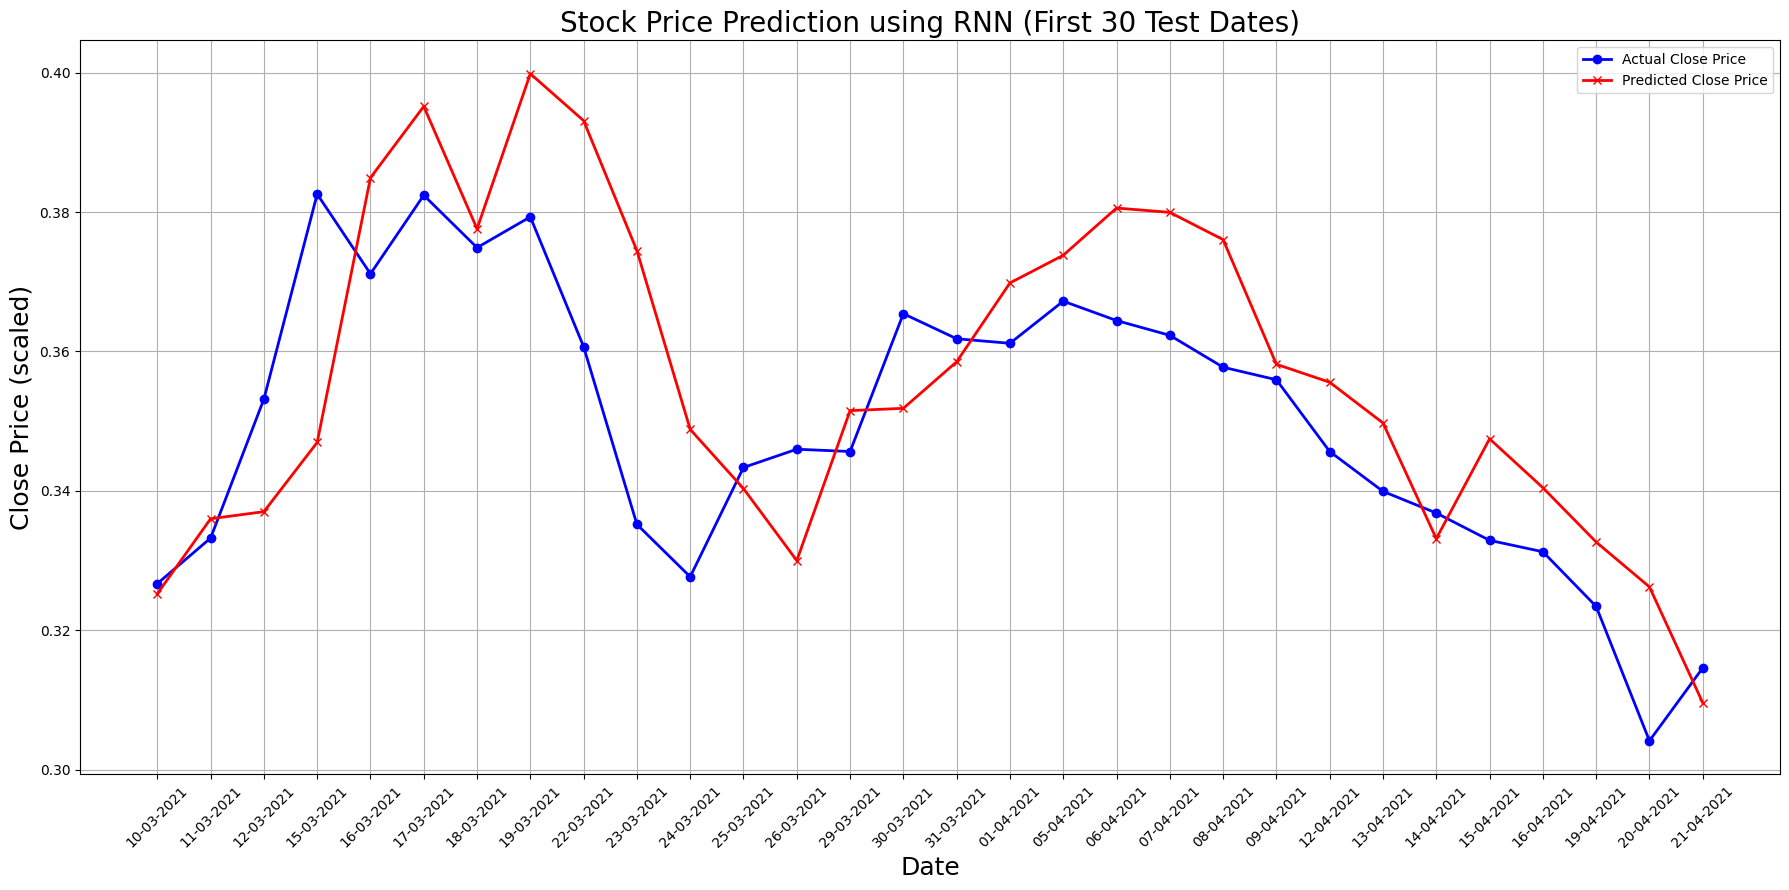

Plot saved as 'rnn_first_30_test_dates_plot.png' with 300 DPI.


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'df' contains the original dataset with a 'Date' column and 'y_test_original' contains actual stock prices
# Extract the correct indices for the test set
test_indices = df.index[-len(y_test_original):]  # Get the last n rows corresponding to the test data

# Extract corresponding dates from the 'Date' column
actual_dates = df.loc[test_indices, 'Date']

# Plot the first 30 test dates along with actual and predicted values
actual_prices = y_test_original[:30]  # Actual stock prices for the first 30 test dates
predicted_prices = predictions_combined[:30, -1]  # Predicted stock prices for the first 30 test dates

# Plotting
plt.figure(figsize=(18, 9))
plt.plot(actual_dates[:30], actual_prices, label="Actual Close Price", color="blue", marker='o', linewidth=2, markersize=6)
plt.plot(actual_dates[:30], predicted_prices, label="Predicted Close Price", color="red", marker='x', linewidth=2, markersize=6)

# Formatting the plot
plt.legend()
plt.title("Stock Price Prediction using RNN (First 30 Test Dates)", fontsize=20)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price (scaled)", fontsize=18)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.tight_layout()

# Save the plot in high resolution (300 DPI)
output_file = "rnn_first_30_test_dates_plot.png"
plt.savefig(output_file, dpi=300)

# Optionally display the plot
plt.show()

print(f"Plot saved as '{output_file}' with 300 DPI.")


In [ ]:

import numpy as np

# Assuming 'y_test_original' are the actual values and 'predictions' are the model predictions
# For example: predictions_combined[:, -1] contains the predictions

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, predictions_combined[:, -1]))

# Calculate MSE
mse = mean_squared_error(y_test_original, predictions_combined[:, -1])

# Calculate MAE
mae = mean_absolute_error(y_test_original, predictions_combined[:, -1])

# Calculate R2
r2 = r2_score(y_test_original, predictions_combined[:, -1])

# Print the metrics
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")


RMSE: 0.009486330659986482
MSE: 8.999046939059955e-05
MAE: 0.0071115627536150455
R²: 0.9715598831378038
